In [105]:
import pandas as pd
from typing import List, Tuple, Dict, Any
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import os
import sys
import random
import matplotlib.pyplot as plt

In [106]:
dataset_name = "m4_yearly_miscellaneous"

In [107]:
input_fname = "m4_yearly_dataset.tsf"
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

# Read Data

In [108]:
def data_line_generator(filepath: str):
    """
    Generator function that yields each line of data after the '@data' marker in the file.

    Args:
    filepath (str): The path to the file from which to read the data.

    Yields:
    str: The next line of data from the file.
    """
    with open(filepath, 'r') as file:
        # Iterate over the file until the '@data' marker is found
        for line in file:
            if line.strip() == "@data":
                break

        # Yield each line of data after the '@data' marker
        for line in file:
            if not line.strip():  # Skip any empty lines that may be present
                continue
            yield line.strip()

In [109]:
def generate_timestamps(start_timestamp_str: str, time_steps: int) -> List[str]:
    """
    Generates a list of yearly timestamps starting with the given timestamp and incrementing by 1 year. 

    Args:
        start_timestamp_str (str): The starting timestamp in string format 'YYYY-MM-DD HH-MM-SS'.
        time_steps (int): The number of yearly time steps to generate.

    Returns:
        List[str]: A list of timestamps in string format incremented yearly.
    """
    # Convert the start timestamp string to a datetime object
    start_timestamp = datetime.strptime(start_timestamp_str, "%Y-%m-%d %H-%M-%S")
    
    # Generate a list of timestamps
    timestamps = [start_timestamp + relativedelta(years=i) for i in range(time_steps)]
    
    # Convert the timestamps back to strings
    timestamp_strs = [timestamp.strftime("%Y-%m-%d %H-%M-%S") for timestamp in timestamps]
    
    return timestamp_strs

# Test the function with a start timestamp and 5 time steps
test_timestamps = generate_timestamps("1979-01-01 12-00-00", 5)
test_timestamps

['1979-01-01 12-00-00',
 '1980-01-01 12-00-00',
 '1981-01-01 12-00-00',
 '1982-01-01 12-00-00',
 '1983-01-01 12-00-00']

# Find most common start and end years of series
Each series in the m4 yearly dataset has it's own start year and end year. We want to find the start-end combinations which have the most number of series. We will pick from that list of series. 

In [110]:
data_gen = data_line_generator(input_fname)

def find_counts_for_series_start_year_and_length(max_series=100000):
    timestamp_lookup_dict = {}
    for i in range(max_series):
        try:
            line = next(data_gen)
            fields = line.split(":")
            series_name = fields[0]
            series_start_datetime = fields[1].strip()
            num_time_steps = len(fields[-1].split(","))
            timestamp_lookup = (series_start_datetime, num_time_steps)
            if timestamp_lookup not in timestamp_lookup_dict:
                timestamp_lookup_dict[timestamp_lookup] = [series_name]
            else: 
                timestamp_lookup_dict[timestamp_lookup].append(series_name)
        except StopIteration: 
            break
        except Exception as e:
            # If any other exception occurs, print the error and the problematic line
            print("An error occurred:", e)
            print("Problematic line:", line)
    return timestamp_lookup_dict

timestamp_lookup_dict = find_counts_for_series_start_year_and_length(max_series=100000)

In [111]:
print(timestamp_lookup_dict[('1970-01-01 12-00-00', 46)])
print(len(timestamp_lookup_dict[('1970-01-01 12-00-00', 46)]))

['T636', 'T637', 'T638', 'T639', 'T640', 'T652', 'T653', 'T654', 'T669', 'T689', 'T690', 'T691', 'T692', 'T693', 'T694', 'T695', 'T696', 'T697', 'T704', 'T705', 'T706', 'T707', 'T708', 'T715', 'T716', 'T717', 'T718', 'T719', 'T720', 'T721', 'T765', 'T766', 'T767', 'T768', 'T795', 'T796', 'T797', 'T808', 'T809', 'T810', 'T811', 'T812', 'T813', 'T814', 'T821', 'T822', 'T823', 'T824', 'T826', 'T837', 'T838', 'T839', 'T840', 'T841', 'T843', 'T844', 'T845', 'T860', 'T861', 'T862', 'T863', 'T864', 'T865', 'T866', 'T867', 'T869', 'T872', 'T873', 'T888', 'T890', 'T891', 'T892', 'T893', 'T894', 'T895', 'T896', 'T952', 'T953', 'T971', 'T972', 'T973', 'T975', 'T976', 'T977', 'T978', 'T981', 'T987', 'T988', 'T989', 'T1047', 'T1049', 'T1050', 'T1051', 'T1060', 'T1064', 'T1065', 'T4179', 'T10533', 'T10534', 'T10535', 'T10536', 'T10537', 'T10538', 'T10540', 'T10541', 'T10542', 'T10543', 'T10544', 'T10545', 'T10546', 'T10562', 'T10563', 'T10564', 'T10565', 'T10566', 'T10567', 'T10571', 'T10574', 'T105

## Filter Series 

In [112]:
# We will now filter data to contain only series which start in the year 1970,
# and which have length 46 (i.e. they end in the year 2015). There are 172 such series.
target_start = '1970-01-01 12-00-00'
target_num_steps = 46

In [113]:
data_gen = data_line_generator(input_fname)

def process_data(max_series=100000):
    df_list = []
    timestamp_lookup_dict = {}
    for i in range(max_series):
        try:
            line = next(data_gen)
            fields = line.split(":")
            series_name = fields[0]
            series_start_datetime = fields[1]
            series_vals = fields[-1].split(",")
            num_time_steps = len(series_vals)
            
            # filter for target start year and num of years
            if series_start_datetime.strip() != target_start or num_time_steps != target_num_steps:
                continue
            timestamp_lookup = (series_start_datetime, num_time_steps)
            if timestamp_lookup not in timestamp_lookup_dict:
                timestamp_lookup_dict[timestamp_lookup] = generate_timestamps(*timestamp_lookup)
            timestamps_list = timestamp_lookup_dict[timestamp_lookup]
            df = pd.DataFrame({'year': timestamps_list})
            df['series'] = series_name
            df['value'] = series_vals
            df['value'] = df['value'].astype(float)
            df_list.append(df)
        except StopIteration: 
            break
        except Exception as e:
            # If any other exception occurs, print the error and the problematic line
            print("An error occurred:", e)
            print("Problematic line:", line)
    all_data = pd.concat(df_list)
    return all_data
        
all_data = process_data()
print(all_data.head())
print(all_data.shape)

                  year series   value
0  1970-01-01 12-00-00   T636  2525.0
1  1971-01-01 12-00-00   T636  2630.0
2  1972-01-01 12-00-00   T636  2760.0
3  1973-01-01 12-00-00   T636  2860.0
4  1974-01-01 12-00-00   T636  2940.0
(7912, 3)


In [114]:
# Convert year to 'YYYY-MM-DD' form
all_data['year'] = all_data['year'].apply(lambda s: s[:10])
print(all_data.head())

         year series   value
0  1970-01-01   T636  2525.0
1  1971-01-01   T636  2630.0
2  1972-01-01   T636  2760.0
3  1973-01-01   T636  2860.0
4  1974-01-01   T636  2940.0


In [115]:
print("length of series", all_data['series'].value_counts().max())
print("number of series: ", all_data['series'].nunique())

length of series 46
number of series:  172


# Sample 100 Series out of 172 series

In [116]:
random.seed(123)
unique_series = all_data['series'].unique().tolist()
sampled_series = random.sample(unique_series, 100)

In [117]:
# Filter to the sample
final_data = all_data[all_data['series'].isin(sampled_series)].reset_index(drop=True)

# Final Data

In [118]:
series_col = "series"
epoch_col = 'year'
epoch_label = "year_num"
time_col = 'year'
value_col = 'value'
exog_cols = []

# Visualize Data

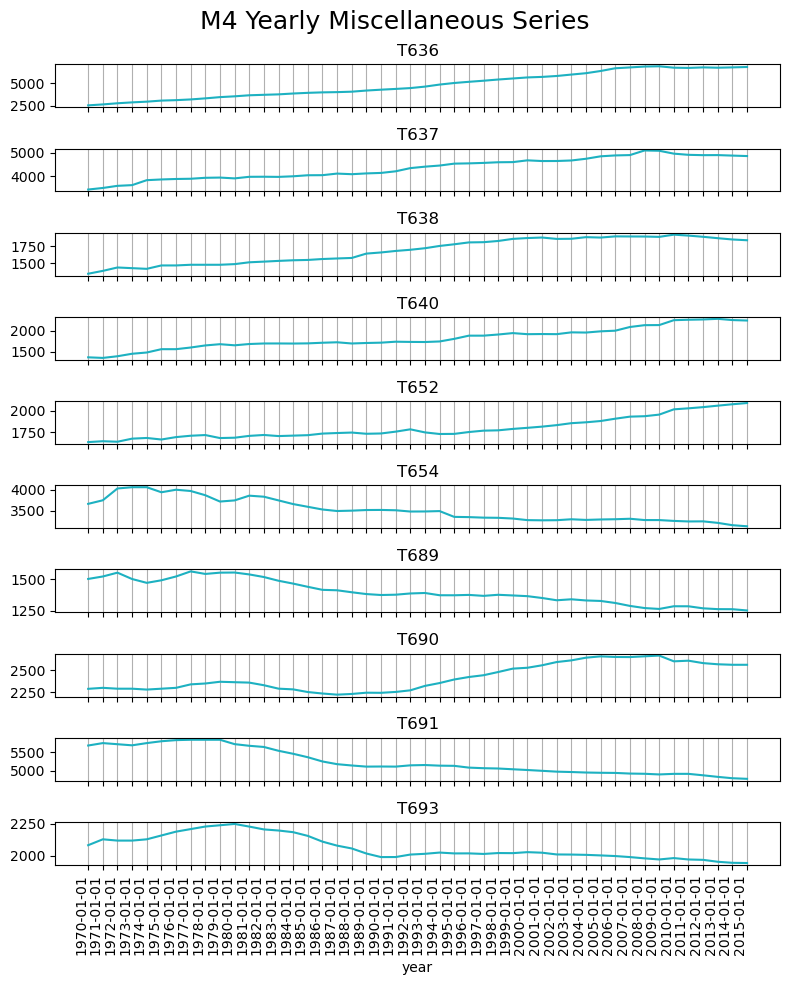

In [119]:
import matplotlib.pyplot as plt

def plot_trends(df, series_col, val_col, epoch_col, epoch_label, num_series=10,
                filepath=outp_fig_fname, chart_title=dataset_name):
    """
    This function takes a dataframe and a number of series to chart.
    It creates a n x 1 subplot (with n being the number of series, at most 10) and plots those series.
    
    Parameters:
    df (DataFrame): dataframe.
    num_series (int): The number of series to plot, defaulted to 10.
    """
    
    # Get the unique series from the dataframe
    unique_series = df[series_col].unique()
    
    # Limit the number of series to plot
    series_to_plot = unique_series[:min(len(unique_series), num_series)]
    
    # Set up the subplots
    fig, axes = plt.subplots(nrows=min(num_series, len(series_to_plot)), ncols=1, figsize=(8, num_series*1))
    
    # If there's only one series to plot, axes will not be an array, so we wrap it in a list
    if num_series == 1:
        axes = [axes]
    
    # Define the color for the plots
    plot_color = '#1db1c1'
    
    # Plot each series on a separate subplot
    for i, (ax, series_id) in enumerate(zip(axes, series_to_plot)):
        # Filter the dataframe for the current series
        series_data = df[df[series_col] == series_id]
                
        # Plot the data
        ax.plot(series_data[epoch_col], series_data[val_col], color=plot_color)
        
        # Set the title and labels
        ax.set_title(series_id)
        # ax.set_ylabel('Trend')
        # Show x-axis grid
        ax.xaxis.grid(True)
        
        # Show x-axis labels only for the last (bottom) plot
        if i < len(series_to_plot) - 1:
            ax.set_xticklabels([])
        else:
            # Rotate date labels to avoid overlap
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, ha='right')
            ax.set_xlabel(epoch_label)            
        
        # Rotate date labels to avoid overlap
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, ha='right')
    
    plt.suptitle(chart_title, fontsize=18)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Save figure
    plt.savefig(filepath)
    
    plt.show()

# Plot a few series
plot_trends(
    final_data,
    series_col=series_col,
    val_col=value_col,
    epoch_col=epoch_col,
    epoch_label='year',
    num_series=10,
    filepath=outp_fig_fname,
    chart_title="M4 Yearly Miscellaneous Series"
)  


# Save Main Data File

In [120]:
if time_col: 
    all_cols = [series_col, time_col, value_col] + exog_cols
else: 
    all_cols = [series_col, value_col] + exog_cols
final_data.sort_values(by=[series_col, epoch_col], inplace=True)

final_data[all_cols].to_csv(outp_fname, index=False)